# KELT-11: Observations and analysis from TESS data

KELT-11 was observed by TESS during its xxth observation sector. In the present notebook, we shall analyse this data observed by TESS. The main aim behind this analysis is just to test the quality of both dataset. And probably, in the future, make some useful results by combining both of the datasets. We will use `juliet` to fit TESS data -- and as explained below, we will use two-step fitting employed by Patel & Espinoza (2021).

This approach to fit data to the given data in two step is implemented in Patel & Espinoza (2021). The idea is to use Gaussian Processes to model the "extra" noise (apart from the transit signal) in the data. This method is in contrast to the method generally used in the analysis by `pycheops` which include *decorrelation* of instrumental parameters (because, we know their properties and can well correct for them). While in this approach we won't follow this --- instead we will directly fit GP noise model to the data. There is a caveat to this approach: if not handled properly, it can produce larger uncertainties in the retrieved planetary parameters (GP can try to fit transit signal as noise). So, what we will do is to fit only out-of-transit data points first (and thus excluding the transit signal). Next we can fit the whole dataset (or just the transit signal) with full model (transit model + GP model) with priors on GP hyperparameters as the posteriors found in the first step.

We will use `juliet` to perform all of these tasks: the main reason for this is that, while `pycheops` can perform GP fitting, it doesn't include versatile GP kernels like Exponential-Matern kernel or Quasi-Periodic kernel. The kernel provided by `pycheops` is SHOTerm which is a simple harmonic oscillator kernel and not as versatile as Exp-Matern kernel or QP kernel.

In the present notebook we will use Exponential-Matern kernel to demonstrate the fitting.

Much of the codes are taken from [https://github.com/nespinoza/tess-limb-darkening](https://github.com/nespinoza/tess-limb-darkening)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pycheops
from uncertainties import ufloat
from uncertainties.umath import sqrt as usqrt
import matplotlib.gridspec as gd
import juliet as jl
import exoctk

/home/jayshil/anaconda3/lib/python3.8/site-packages/autograd/numpy/numpy_wrapper.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  int_types = {_np.int, _np.int8, _np.int16, _np.int32, _np.int64, _np.integer}


pandeia not installed. Functionality limited.
Could not determine exoctk version


## Downloading the data

As mentioned, we are going to use `pycheops` to download the data and extracting time, flux and uncertainties in flux from the data.

In [2]:
# Downloading TESS data
tim, fl, fle = jl.utils.get_all_TESS_data('TIC 55092869')

# Let's see in what sector did TESS observe KELT-11
print(tim.keys())

dict_keys(['TESS9'])


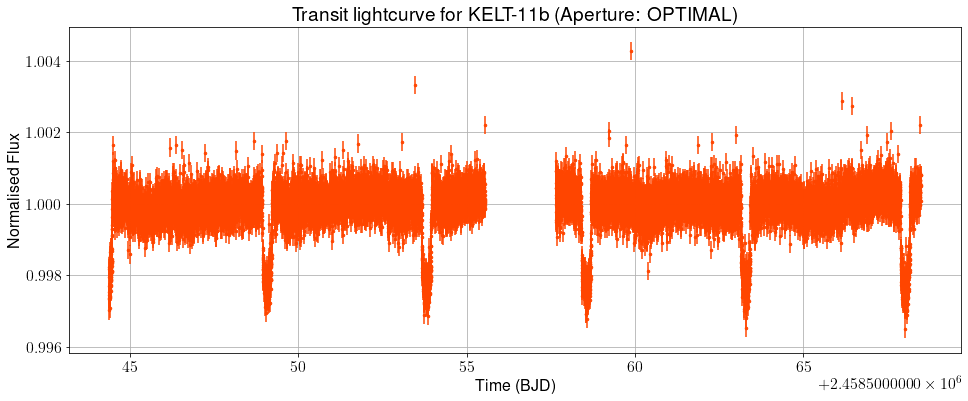

In [3]:
# So, it was observed during Sector 9
# Plotting the data
plt.figure(figsize=(16,6))
plt.errorbar(tim['TESS9'], fl['TESS9'], yerr=fle['TESS9'], fmt='.', c='orangered')
plt.xlabel('Time (BJD)')
plt.ylabel('Normalised Flux')
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)')
plt.grid()

### Planetary Properties

Let's now extract planetary and stellar properties from online database (this would be helpful in determining priors on fit).

In [4]:
## Some useful analysis of planetary properties

# Exposure time of 2-min cadence data, in days:
exp_time = (2./60.)/24.

# Let's retrieve planet data from exoctk first
planet_data, url = exoctk.utils.get_target_data('KELT-11b')

# Extract useful data of planetary parameters:
tdur = planet_data['transit_duration']
tdepth = planet_data['transit_depth']
period = planet_data['orbital_period']
period_err = (planet_data['orbital_period_upper'] + planet_data['orbital_period_lower'])*0.5
if (type(planet_data['eccentricity']) != float or type(planet_data['omega']) != float):
    ecc, omega = 0., 0.
else:
    ecc, omega = planet_data['eccentricity'], planet_data['omega']

##
t0 = planet_data['transit_time'] + 2400000.5  # This would not be in the observation period
t0_err = (planet_data['transit_time_upper'] + planet_data['transit_time_lower'])*0.5

nn = int(np.mean(tim['TESS9']) - t0)
t0 = t0 + nn*period
t0_err = np.sqrt(t0_err**2 + (nn*period)**2)

## Fitting Out-of-transit lightcurve

First we fit a GP model along with instrumental parameters to the out-of-transit parameters. To do this, let's first identify out-of-transit data first.

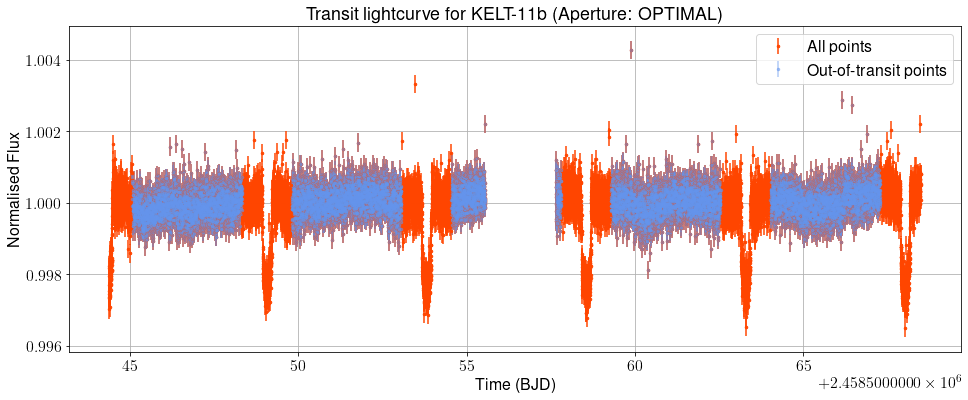

In [5]:
# Select only out-of-transit data. For this, work on phase-space:
phases = jl.utils.get_phases(tim['TESS9'], period, t0)
idx_oot = np.where(np.abs(phases*period) >= 5.*tdur*0.5)[0]

# Data dictionary for out of transit
tim_oot, fl_oot, fle_oot = {}, {}, {}
tim_oot['TESS9'], fl_oot['TESS9'], fle_oot['TESS9'] = tim['TESS9'][idx_oot], fl['TESS9'][idx_oot], fle['TESS9'][idx_oot]

# Data dictionary for full dataset
tim_full, fl_full, fle_full = {}, {}, {}
tim_full['TESS9'], fl_full['TESS9'], fle_full['TESS9'] = tim['TESS9'], fl['TESS9'], fle['TESS9']

# Plotting the data
plt.figure(figsize=(16,6))
plt.errorbar(tim['TESS9'], fl['TESS9'], yerr=fle['TESS9'], fmt='.', c='orangered', label='All points')
plt.errorbar(tim['TESS9'][idx_oot], fl['TESS9'][idx_oot], yerr=fle['TESS9'][idx_oot], fmt='.', c='cornflowerblue', alpha=0.5, label='Out-of-transit points')
#plt.axvline(x=T_0, c='k', lw=3)
#plt.axvline(x=T_0-(W*P/2), c='cornflowerblue', lw=3)
#plt.axvline(x=T_0+(W*P/2), c='cornflowerblue', lw=3)
plt.xlabel('Time (BJD)', fontsize=16)
plt.ylabel('Normalised Flux', fontsize=16)
plt.title('Transit lightcurve for KELT-11b (Aperture: OPTIMAL)', fontsize=18)
plt.legend(fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.grid()

In [6]:
# Instrumental parameters
params_ins = ['mdilution_TESS9', 'mflux_TESS9', 'sigma_w_TESS9']
dist_ins = ['fixed', 'normal', 'loguniform']
hyper_ins = [1., [0., 0.1], [0.1, 10000.]]

# GP Params
params_gp = ['GP_sigma_TESS9', 'GP_timescale_TESS9', 'GP_rho_TESS9']
dist_gp = ['loguniform', 'loguniform', 'loguniform']
hyper_gp = [[1e-5, 10000.], [1e-3, 1e2], [1e-3, 1e2]]

## Performing GP fit
params_gp_only = params_ins + params_gp
dist_gp_only = dist_ins + dist_gp
hyper_gp_only = hyper_ins + hyper_gp

### Populating prior dict
priors = {}
for i, j, k in zip(params_gp_only, dist_gp_only, hyper_gp_only):
    priors[i] = {}
    priors[i]['distribution'], priors[i]['hyperparameters'] = j, k

## Running GP only fit
data = jl.load(priors=priors, t_lc=tim_oot, y_lc=fl_oot, yerr_lc=fle_oot, GP_regressors_lc=tim_oot, out_folder='juliet/juliet_oot_TESS_exp')
res_gp_only = data.fit(n_live_points = 500, verbose = True)

Detected multinest sampler output files --- extracting from juliet/juliet_oot_TESS_exp/posteriors.pkl


## Full GP fitting

In [7]:
# Now we will use posteriors from GP parameters as priors in next full GP fitting
# This will give us the priors on GP parameters
for i in range(len(params_gp)):
    post1 = res_gp_only.posteriors['posterior_samples'][params_gp[i]]
    mu, sig = np.median(post1), np.std(post1)
    dist_gp[i] = 'truncatednormal'
    hyper_gp[i] = [mu, sig, hyper_gp[i][0], hyper_gp[i][1]]

# Doing the same for instrumental parameters
# For sigma_w_CHEOPS
dist_ins[2] = 'truncatednormal'
post2 = res_gp_only.posteriors['posterior_samples']['sigma_w_TESS9']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[2] = [mu, sig, hyper_ins[2][0], hyper_ins[2][1]]
# For mflux
dist_ins[1] = 'normal'
post2 = res_gp_only.posteriors['posterior_samples']['mflux_TESS9']
mu, sig = np.median(post2), np.std(post2)
hyper_ins[1] = [mu, sig]

# Defining planetary parameters
params_P = ['P_p1', 't0_p1', 'r1_p1', 'r2_p1', 'q1_TESS9', 'q2_TESS9', 'ecc_p1', 'omega_p1', 'a_p1']
dist_P = ['fixed', 'normal', 'uniform', 'uniform', 'uniform', 'uniform', 'fixed', 'fixed', 'loguniform']
hyper_P = [period, [t0, 0.1], [0.,1.], [0.,1.], [0.,1.], [0.,1.], ecc, omega, [1.,100.]]

## Making prior dictionary
params = params_P + params_ins + params_gp
dist = dist_P + dist_ins + dist_gp
hyper = hyper_P + hyper_ins + hyper_gp

for i, j, k in zip(params, dist, hyper):
    priors[i] = {}
    priors[i]['distribution'], priors[i]['hyperparameters'] = j, k

# And fitting
data_full = jl.load(priors=priors, t_lc=tim_full, y_lc=fl_full, yerr_lc=fle_full, GP_regressors_lc=tim_full, out_folder='juliet/juliet_full_TESS_exp')
results_full = data_full.fit(n_live_points=500, verbose=True)

Detected multinest sampler output files --- extracting from juliet/juliet_full_TESS_exp/posteriors.pkl


Let's plot the results...

(2458544.385837514, 2458568.480077524)

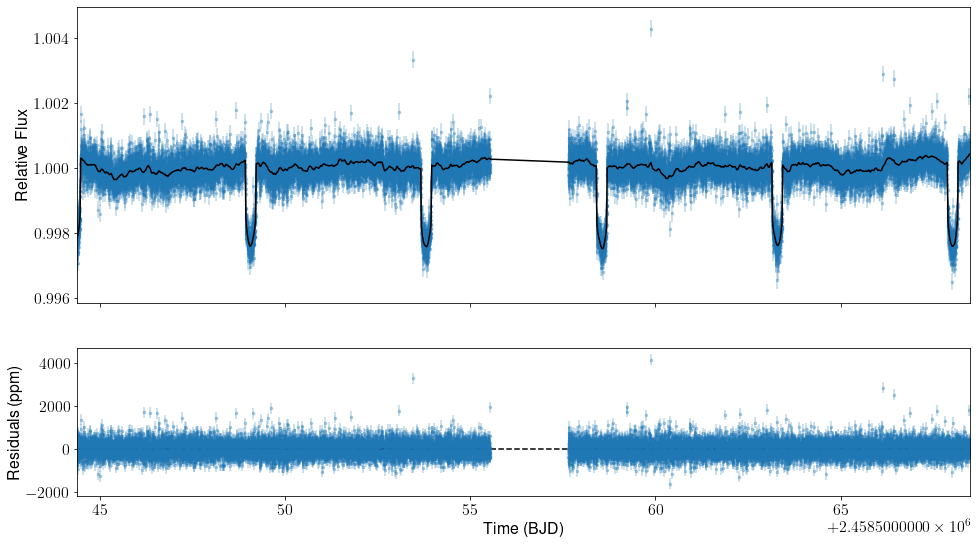

In [8]:
# juliet best fit model
model = results_full.lc.evaluate('TESS9')

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(tim_full['TESS9'], fl_full['TESS9'], yerr=fle_full['TESS9'], fmt='.', alpha=0.3)
ax1.plot(tim_full['TESS9'], model, c='k', zorder=100)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(np.min(tim_full['TESS9']), np.max(tim_full['TESS9']))
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(tim_full['TESS9'], (fl_full['TESS9']-model)*1e6, yerr=fle_full['TESS9']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Time (BJD)')
ax2.set_xlim(np.min(tim_full['TESS9']), np.max(tim_full['TESS9']))

(-2000.0, 2000.0)

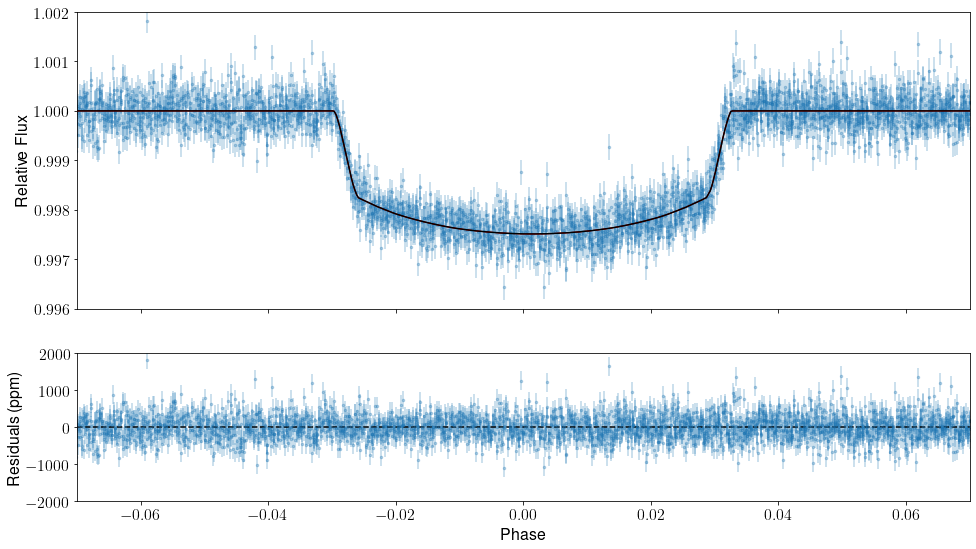

In [9]:
idx = np.argsort(phases)

# juliet best fit GP el
gp_model = results_full.lc.model['TESS9']['GP']

# juliet best fit transit model and its errors
transit_model = results_full.lc.model['TESS9']['deterministic']
transit_model_err = results_full.lc.model['TESS9']['deterministic_errors']
umodel, lmodel = transit_model + transit_model_err, transit_model - transit_model_err

# Normalising the data and fitting
fac = 1/np.max(transit_model)

# Making a plot
fig = plt.figure(figsize=(16,9))
gs = gd.GridSpec(2,1, height_ratios=[2,1])

# Top panel
ax1 = plt.subplot(gs[0])
ax1.errorbar(phases, (fl_full['TESS9']-gp_model)*fac, yerr=fle_full['TESS9'], fmt='.', alpha=0.3)
ax1.plot(phases[idx], transit_model[idx]*fac, c='k', zorder=100)
ax1.fill_between(phases[idx], umodel[idx]*fac, lmodel[idx]*fac, color='red', alpha=0.7, zorder=5)
ax1.set_ylabel('Relative Flux')
ax1.set_xlim(-0.07, 0.07)
ax1.set_ylim(0.996, 1.002)
ax1.xaxis.set_major_formatter(plt.NullFormatter())

# Bottom panel
ax2 = plt.subplot(gs[1])
ax2.errorbar(phases, (fl_full['TESS9']-gp_model-transit_model)*1e6*fac, yerr=fle_full['TESS9']*1e6, fmt='.', alpha=0.3)
ax2.axhline(y=0.0, c='black', ls='--')
ax2.set_ylabel('Residuals (ppm)')
ax2.set_xlabel('Phase')
ax2.set_xlim(-0.07, 0.07)
ax2.set_ylim(-2000,2000)

It seems that the fit was good?! Let's check the evidence in favour of this 

In [10]:
print(results_full.posteriors['lnZ'])

103253.11179857307
